In [ ]:
#!pip install -r requirements.txt

# Load configuration file

In [1]:
import yaml
from argparse import Namespace
with open('config.yaml') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
cfg = Namespace(**dict(cfg))

onePilotFolder = cfg.DMRS_signal_path
path = cfg.file_path


In [2]:
from __future__ import print_function
import numpy as np
from scipy.io import loadmat
from collections import namedtuple
import torch
#from torch.nn import functional as F
from matplotlib import pyplot as plt
from torch.optim import Adam, SGD
import os
import hashlib 
#from torchviz import make_dot
import time 
from torch import tensor
import pprint
from scipy.io import loadmat
from tqdm import tqdm_notebook
from torch.fft import fftn, ifftn

#------- GLOBAL SETTINGS

#deviceType = 'cuda' 
deviceType = 'cpu'

if deviceType == 'cuda':
    print ('Using GPU\n')
    assert torch.cuda.is_available()
    device = torch.device('cuda')
    dtype = torch.float32
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
        
elif deviceType == 'cpu':
    print ('Using CPU\n')
    device = torch.device('cpu')
    dtype = torch.float32# was 64    
    torch.set_default_tensor_type(torch.FloatTensor)#(torch.DoubleTensor)

Scenario = namedtuple('Scenario', [
    'SNR', 'seed','index', 'RB_num', 'N_TTI', 'UE_indx', 'UE_number', 'beam_transform', 'N_ports', 
    'N_seeds', 'N_scenarios', 'N_pilot', 'RB_size', 'Nrx', 'upsample_factor', 'Nfft', 'N_shift', 'N_response','comb'])

# Here base parameters of scenario are defined
scen0 = Scenario(SNR=0, seed=0,  RB_num = 4, index=1, beam_transform = 0, N_ports = 16,
                    N_TTI=1, UE_indx=0, UE_number=1, N_seeds=4, N_scenarios=140, RB_size=12, N_pilot=2, Nrx=64,
                    upsample_factor=1, Nfft=512, N_shift=10, N_response=448*512//2048, comb = 0)

# Preload all mat files
preload = True

#------- END OF GLOBAL SETTINGS

def data_load(scen,
              ind=None, # index of mat file, can be used instead of path
              path=None, 
              scaleFactor=1e4, # rescale data so that it is of order ~1e0  
              use_preloaded=True,
              ):   
    '''
    Returns 4D tensors h_pilot, h_data, with dimensions:   
    1 - antenna number (up to Nrx)
    2 - frequency/time position 
    3 - symbol index (up to N_pilot_sym or N_data_sym)
    4 - real/imag component   
    '''
    comb=scen.comb
    # N-of-pilot-symbols
    N_pilot_sym = scen.N_pilot*scen.N_TTI
    N_data_sym = (14-N_pilot_sym)*scen.N_TTI;
    assert (N_pilot_sym == 1 or N_pilot_sym == 2)
    if N_pilot_sym == 1:
        pilot_positions = [3]
    elif N_pilot_sym == 2:
        pilot_positions = [3, 10]
        
    N_used = scen.RB_num*scen.RB_size    
    
    if path is None:
        assert (not ind is None)
        path = os.path.join(onePilotFolder, 'temp_chan_seed'+str(ind)+'.mat')
        
    if use_preloaded:
        assert (not ind is None)
        return dataL[ind-1]

    H_tmp = loadmat(path)['H_new']
    
    # Extract pilot symbols
    h_pilot = torch.zeros(scen.Nrx, N_used, N_pilot_sym, 2)
    for s in range(N_pilot_sym):
        h_pilot[:,0:N_used:(1+comb),s,0] = torch.sqrt(torch.tensor(1+comb, dtype=dtype))*torch.tensor(H_tmp[0,:scen.Nrx,0:N_used:(1+comb), pilot_positions[s]].real)
        h_pilot[:,0:N_used:(1+comb),s,1] = torch.sqrt(torch.tensor(1+comb, dtype=dtype))*torch.tensor(H_tmp[0,:scen.Nrx,0:N_used:(1+comb), pilot_positions[s]].imag)
    
    # Extract data symbols
    h_data = torch.zeros(scen.Nrx, N_used, N_data_sym, 2)
    s = 0
    for k in range(14):
        if not k in pilot_positions:
            h_data[:,:,s,0] = torch.tensor(H_tmp[0,:scen.Nrx,0:N_used, k].real)
            h_data[:,:,s,1] = torch.tensor(H_tmp[0,:scen.Nrx,0:N_used, k].imag)
            s += 1
    
    h_pilot *= scaleFactor
    h_data *= scaleFactor
    
    return h_pilot, h_data


# Preload all mat files
if preload:
    dataL = []
    dataS = []
    for ind in range(1,141):
        path = os.path.join(onePilotFolder, 'temp_chan_seed'+str(ind)+'.mat')
        h_pilot, h_data = data_load(scen=scen0, ind=ind, use_preloaded=False)
        dataL.append([h_pilot, h_data])
    print ('Preload data: OK')


        
def upsampling(scen, h, inverse=False): # inverse: inverse transform to frequency domain
    N_used = scen.RB_num*scen.RB_size
    XZ = scen.upsample_factor*scen.Nfft
    if not inverse:
        assert len(h.shape) == 3 or len(h.shape) == 4
        if len(h.shape) == 3:
            assert h.shape[1] >= N_used and h.shape[-1] == 2
            h_f = torch.zeros((h.shape[0], XZ, 2))
            h_f[:,:N_used] = h
            h_f_rolled = torch.roll(h_f, -N_used//2, dims=1)
            h_ifft = torch.ifft(h_f_rolled, signal_ndim=1, normalized=True)

            h_t = torch.roll(h_ifft, scen.N_shift, dims=1)
        elif len(h.shape) == 4:
            assert h.shape[1] >= N_used and h.shape[-1] == 2
            h_t = torch.zeros((h.shape[0], XZ, h.shape[2], 2))
            for k in range(h.shape[2]):
                h_t[:,:,k] = upsampling(scen, h[:,:,k], inverse=False)
        return h_t
    
    else:
        if len(h.shape) == 3:
            h_t_rolled = torch.roll(h, -scen.N_shift, dims=1)
            h_fft = torch.fft(h_t_rolled, signal_ndim=1, normalized=True)
            
            h_f = torch.roll(h_fft, N_used//2, dims=1)
        elif len(h.shape) == 4:
            h_f = torch.zeros_like(h)
            for k in range(h.shape[2]):
                h_f[:,:,k] = upsampling(scen, h[:,:,k], inverse=True)
        return h_f
    
def getSeed(h, seed):
    '''Form a new seed, given another seed and h'''
    t = (str(float(h.sum()))+'_'+str(h.shape[2])+'_'+str(seed)).encode()
    hash_ = hashlib.md5(t).hexdigest() # get hash
    as_int = int(hash_, 16)
    short = as_int % (1 << 16)
    return short

def add_noise(h, SNR, seed=None, scen=scen0):#only for pilot symbols
    N_used = scen.RB_num*scen.RB_size
    if not seed is None:
        torch.manual_seed(getSeed(h, seed))
    UE_power = 2*(h**2).mean() # 2 because of averaging over real and imag components
    white_noise_p = torch.randn(h.size())
    white_noise_p /= np.sqrt(2)
    noise_p = torch.sqrt(UE_power) * white_noise_p / np.sqrt(10**(SNR/10.))
    h_noisy = h + noise_p
    if scen.comb == 1:
        comb_matrix=torch.ones(scen.Nrx, N_used, scen.N_pilot,2, dtype=dtype)
        comb_matrix[:,1:N_used:2,:, :]=torch.zeros(scen.Nrx, N_used//2, scen.N_pilot, 2, dtype=dtype)
        h_noisy=h_noisy*comb_matrix
        
    assert h_noisy.dtype == dtype
    noise_power = 2*(noise_p**2).mean()
    return h_noisy, noise_power  

def add_noise_data(h, SNR, seed=None):#only for data symbols
    if not seed is None:
        torch.manual_seed(getSeed(h, seed))
    UE_power = 2*(h**2).mean() # 2 because of averaging over real and imag components
    white_noise_p = torch.randn(h.size())
    white_noise_p /= np.sqrt(2)
    noise_p = torch.sqrt(UE_power) * white_noise_p / np.sqrt(10**(SNR/10.))
    h_noisy = h + noise_p
    assert h_noisy.dtype == dtype
    noise_power = 2*(noise_p**2).mean()
    return h_noisy, noise_power

def noise_estim(scen, h_t_noisy):
    XZ = scen.upsample_factor*scen.Nfft
    if scen.comb == 1:
        length = int(XZ*((1./2-1./16) - (1./4+1./16)))+int(XZ*((1.-1./16) - (3./4+1./16)))
        x = int(XZ*((1./2-1./16) - (1./4+1./16)))
        y = int(XZ*(1./4+1./16))
        w = int(XZ*(3./4+1./16))
        z = int(XZ*(1.-1./16))
        assert (len(h_t_noisy.shape) == 3 or len(h_t_noisy.shape) == 4)
        if len(h_t_noisy.shape) == 3:
            noise_array = torch.zeros((h_t_noisy.shape[0], length, 2))
            noise_array[:, :x, :] = h_t_noisy[:,y:x+y]
            noise_array[:, x:, :] = h_t_noisy[:,w:z]        
            noise_tmp = noise_array[:, :, 0]**2+noise_array[:, :, 1]**2
        elif len(h_t_noisy.shape) == 4:       
            noise_tmp = torch.zeros((h_t_noisy.shape[0], length))
            noise_tmp[:, :x] = 2*((h_t_noisy**2)[:,y:x+y]).mean(dim=(2,3))
            noise_tmp[:, x:] = 2*((h_t_noisy**2)[:,w:z]).mean(dim=(2,3))
    else:
        length = int(XZ*((1.-1./16) - (3./4-1./16)))
        w = int(XZ*(3./4-1./16))
        z = int(XZ*(1.-1./16))
        assert (len(h_t_noisy.shape) == 3 or len(h_t_noisy.shape) == 4)
        if len(h_t_noisy.shape) == 3:
            noise_array = torch.zeros((h_t_noisy.shape[0], length, 2))
            noise_array[:, :, :] = h_t_noisy[:,w:z]        
            noise_tmp = noise_array[:, :, 0]**2+noise_array[:, :, 1]**2
        elif len(h_t_noisy.shape) == 4:       
            noise_tmp = torch.zeros((h_t_noisy.shape[0], length))
            noise_tmp[:, :] = 2*((h_t_noisy**2)[:,y:x+y]).mean(dim=(2,3))
    noise_per_sc=torch.sum(noise_tmp)/(scen.N_pilot*4.)#noise per subcarrier
    NS2 = noise_per_sc/XZ
    noise_per_sample1= torch.sum(torch.sum(noise_tmp[0:h_t_noisy.shape[0]:2,:],dim=0))/(XZ/4.)
    noise_per_sample2= torch.sum(torch.sum(noise_tmp[1:h_t_noisy.shape[0]:2,:],dim=0))/(XZ/4.)
    noise_per_sample = noise_per_sample1+noise_per_sample2
    return noise_per_sample, NS2

def SNR_estim(h_t_noisy, 
              scen, 
              clamp=-30 # min value 
              ):
    ''' Estimate SNR''' 
    XZ = scen.upsample_factor*scen.Nfft
    noise_per_sample, _ = noise_estim(scen, h_t_noisy)    
    if len(h_t_noisy.shape) == 3:
        full_power_per_pilot = (h_t_noisy**2).sum()
    elif len(h_t_noisy.shape) == 4:
        full_power_per_pilot = ((h_t_noisy**2).mean(dim=2)).sum()
    noise_power_est = noise_per_sample*XZ
    signal_power_est = max(full_power_per_pilot-noise_power_est, 1e-10)
    SNR_est = max(torch.log10(signal_power_est/noise_power_est)*10., clamp)
    #print(SNR_est)
    return SNR_est  

def SNR_estim1(h_t_noisy, 
              scen, 
              clamp=-30 # min value 
              ):
    ''' Estimate SNR''' 
    XZ = scen.upsample_factor*scen.Nfft
    noise_per_sample, _ = noise_estim(scen, h_t_noisy)    
    if len(h_t_noisy.shape) == 3:
        full_power_per_pilot = (h_t_noisy**2).sum()
    elif len(h_t_noisy.shape) == 4:
        full_power_per_pilot = ((h_t_noisy**2).mean(dim=2)).sum()
    noise_power_est = noise_per_sample*XZ
    signal_power_est = max(full_power_per_pilot-noise_power_est, 1e-10)
    SNR_est = max(torch.log10(signal_power_est/noise_power_est)*10., clamp)
    #print(SNR_est)
    return SNR_est, signal_power_est, noise_power_est  

def softmax_simple(scen, h_up, ml, ml_version=0, additional_data=None):
    assert len(h_up.shape) == 3 and h_up.shape[2] == 2
    SNR_est = SNR_estim(h_up, scen)
    XZ = scen.upsample_factor*scen.Nfft
    power = (h_up[:, :, 0]**2+h_up[:, :, 1]**2).sum(dim=0)
    mean_power = power.mean()
    if ml_version == 12:
        max_power = torch.max(power)
        if scen.comb==0:
            x = torch.arange(len(power), device=device, dtype=dtype)
        else:
            z = torch.arange(len(power)//2, device=device, dtype=dtype)
            y = torch.zeros(len(power)//2, device=device, dtype=dtype)
            first = torch.cat((z, y), dim=0)
            second = torch.cat((y, z), dim=0)
            x = first+second
            
        soft_m = torch.exp(ml['softm_main_scale']+ml['softm_SNR_scale']*SNR_est+ml['max_power_scale']*max_power/mean_power
                          +ml['bayes_exp_c0']+ml['bayes_exp_c1']*x)
        soft_m = soft_m*torch.sigmoid((ml['sigm_power']+ml['max_power_sigm']*max_power/mean_power+
                                       ml['sigm_SNR']*SNR_est+ml['sigm_SNR1']*SNR_est**2)*power/mean_power
                                      +ml['bayes_sigm_c0']+ml['bayes_sigm_c1']*x)
        soft_m = soft_m*torch.softmax((ml['softm_power']+ml['max_power_softm']*max_power/mean_power+
                                       ml['softm_SNR']*SNR_est+ml['softm_SNR1']*SNR_est**2)*power/mean_power
                                      +ml['bayes_softm_c0']+ml['bayes_softm_c1']*x, 0)

    return soft_m
    

    

def extract_peak_simple(scen, h_f, ml, ml_version=0, additional_data=None):    
    N_used = scen.RB_num*scen.RB_size
    XZ = scen.upsample_factor*scen.Nfft
    h_t = upsampling(scen, h_f)
    #plt.figure(figsize=(20, 5))#
    #plt.plot(h_t[13, :, 0].data.numpy(), label='intial')#
    soft_m = softmax_simple(scen, h_t, ml, ml_version=ml_version, additional_data=additional_data)
    h_peak0 = h_t*soft_m.view(1, len(soft_m), 1)
    
    #plt.plot(h_peak0[13, :, 0].data.numpy(), label='softmax')#
    #plt.legend()#
    h_peak_f_minus = upsampling(scen, h_peak0, inverse=True)[:,:N_used]
    if scen.comb==1:
        h_peak_f_plus1 = h_peak_f_minus
        h_peak_f_plus2 = upsampling(scen, torch.cat((h_peak0[:, :XZ//2],-h_peak0[:, XZ//2:]), dim=1), inverse=True)[:,:N_used]
        h_peak_f_plus = (h_peak_f_plus1+h_peak_f_plus2)/torch.sqrt(torch.tensor(2.))
    else:
        h_peak_f_plus = h_peak_f_minus
    
    return h_peak_f_minus, h_peak_f_plus

    
def recover_h(scen, h_f, ml, max_iter, ml_version=1):
    if len(h_f.shape) == 4:
        h_f = h_f.mean(dim=2)
    
    if 'Nrepeats_' in ml.keys():
        extracted_peaks = [0 * h_f for _ in range(max_iter)]
        recovered_peaks = [0 * h_f for _ in range(max_iter)]
        for _ in range(int(ml['Nrepeats_'])):
            for it in range(max_iter):
                additional_data = {'current_iter': it}
                h_f = h_f + extracted_peaks[it]
                h_recovered_current_minus, h_recovered_current_plus = extract_peak_simple(scen, h_f, ml, ml_version=ml_version,
                                                                     additional_data=additional_data)
                h_f = h_f - h_recovered_current_minus
                extracted_peaks[it] = h_recovered_current_minus
                recovered_peaks[it] = h_recovered_current_plus

        h_f_recovered = 0 * h_f
        for it in range(max_iter):
            h_f_recovered = h_f_recovered + recovered_peaks[it]
        
        return h_f_recovered
            
            
    h_f_recovered = 0*h_f
    for it in range(max_iter): 
        additional_data = {'current_iter': it}       
        h_recovered_current_minus, h_recovered_current_plus = extract_peak_simple(scen, h_f, ml, ml_version=ml_version, 
                                                                                  additional_data=additional_data)            
        h_f = h_f - h_recovered_current_minus
        h_f_recovered = h_f_recovered + h_recovered_current_plus
        
    return h_f_recovered    

if scen0.comb:
    ml_default =  {'Nrepeats_': 3.0, 
                 "bayes_exp_c0": tensor(0.0139,requires_grad=True), 
                 "bayes_exp_c1": tensor(-0.0015,requires_grad=True), 
                 "bayes_sigm_c0":tensor( 6.5721e-05,requires_grad=True), 
                 "bayes_sigm_c1": tensor(0.0012,requires_grad=True), 
                 "bayes_softm_c0": tensor(-1.4449e-05,requires_grad=True), 
                 "bayes_softm_c1": tensor(-0.0289,requires_grad=True), 
                 "max_power_scale": tensor(-0.0085,requires_grad=True), 
                 "max_power_sigm": tensor(0.0025,requires_grad=True), 
                 "max_power_softm":tensor( -0.0515,requires_grad=True), 
                 "sigm_SNR": tensor(-0.0312,requires_grad=True), 
                 "sigm_SNR1":tensor( 0.0363,requires_grad=True), 
                 "sigm_power":tensor( 0.4335,requires_grad=True), 
                 "softm_SNR": tensor(-0.1029,requires_grad=True), 
                 "softm_SNR1":tensor( 0.0023,requires_grad=True), 
                 "softm_SNR_scale": tensor(0.0009,requires_grad=True), 
                 "softm_main_scale": tensor(3.1650, requires_grad=True), 
                 "softm_power": tensor(1.5367, requires_grad=True)}
else:
    ml_default =  {'Nrepeats_': 3.0, 
                 "bayes_exp_c0": tensor(0.0023,requires_grad=True), 
                 "bayes_exp_c1": tensor(-0.0029,requires_grad=True), 
                 "bayes_sigm_c0":tensor( 2.0657e-07,requires_grad=True), 
                 "bayes_sigm_c1": tensor(4.7729e-06,requires_grad=True), 
                 "bayes_softm_c0": tensor(-1.7706e-10,requires_grad=True), 
                 "bayes_softm_c1": tensor(-0.0161,requires_grad=True), 
                 "max_power_scale": tensor(0.0087,requires_grad=True), 
                 "max_power_sigm": tensor(0.0012,requires_grad=True), 
                 "max_power_softm":tensor( 0.0012,requires_grad=True), 
                 "sigm_SNR": tensor(-0.0302,requires_grad=True), 
                 "sigm_SNR1":tensor( 0.0314,requires_grad=True), 
                 "sigm_power":tensor( 0.4333,requires_grad=True), 
                 "softm_SNR": tensor(-0.1226,requires_grad=True), 
                 "softm_SNR1":tensor( 0.0008,requires_grad=True), 
                 "softm_SNR_scale": tensor(0.0122,requires_grad=True), 
                 "softm_main_scale": tensor(2.3634, requires_grad=True), 
                 "softm_power": tensor(1.5415, requires_grad=True)}

def getDetectorError(ml = ml_default, 
            lossVersion='detector', # 'detector' or 'relError'
            inds=range(1,141), 
            SNR_L=range(-10,-1), 
            seed=4, 
            max_iter=3, 
            ml_version=12, 
            SNRscaleFactor=1.,
            scen=scen0, scale=True):
    assert lossVersion in ['detector', 'relError']
    N_used = scen.RB_num*scen.RB_size
    loss = []
    comb = scen.comb
 
    if lossVersion == 'detector':
        N_pilot_sym = scen.N_pilot*scen.N_TTI
        N_data_sym = (14-N_pilot_sym)*scen.N_TTI;
        for SNR in SNR_L:
            loss_current = 0
            for ind in inds:
                h_pilot, h_data = data_load(scen, ind=ind+1, use_preloaded=False)
                h_pilot_noisy, _ = add_noise(h_pilot, SNR, seed=seed)
                h_data_noisy, data_noise_power = add_noise_data(h_data, SNR, seed=seed) 
                
                # CHANNEL ESTIMATION  
                h_pilot_rec = recover_h(scen, h_pilot_noisy, ml, 
                    max_iter=max_iter, ml_version=ml_version)
                
                # Show time domain recovered and initial signals
                if ind % 70==-1:
                    h_pilot_rec_numpy = upsampling(scen, h_pilot_rec, inverse=False).detach().numpy()
                    plt.plot(h_pilot_rec_numpy[0,:,0]**2+h_pilot_rec_numpy[0,:,1]**2)
                    h_f = h_pilot
                    if len(h_f.shape) == 4:
                        h_f = h_f.mean(dim=2)
                    h_f = upsampling(scen, h_f, inverse=False).detach().numpy()
                    plt.plot(h_f[0,:,0]**2+h_f[0,:,1]**2)
                    plt.show()            
                assert h_pilot_rec.shape[1] == N_used
                H_re = h_pilot_rec[:, :, 0]
                H_im = -h_pilot_rec[:, :, 1]
                
                # Detector error calculation
                err_data = 0
                for k in range (N_data_sym):    
                    det_data = torch.zeros((N_used, 2))   
                    assert h_data_noisy.shape[1] == N_used 
                    Y = h_data_noisy[:, :, k, :]                    
                    det_data[:,0] = (torch.sum(Y[:,:,0]*H_re-Y[:,:,1]*H_im, dim=0)/
                                    (data_noise_power+torch.sum(H_re**2+H_im**2, dim=0)))
                    det_data[:,1] = (torch.sum(Y[:,:,1]*H_re+Y[:,:,0]*H_im, dim=0)/
                                    (data_noise_power+torch.sum(H_re**2+H_im**2, dim=0)))
                      
                    err = det_data - torch.Tensor([1.,0.])  
                    err_data = err_data+torch.sum(err**2)
    
                loss_current += err_data/(N_data_sym*N_used)
            loss.append(loss_current)        
            
    return loss

Using CPU

Preload data: OK


/home/alex/anaconda3/envs/base37/lib/python3.7/site-packages/ipykernel_launcher.py:129: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:578.)


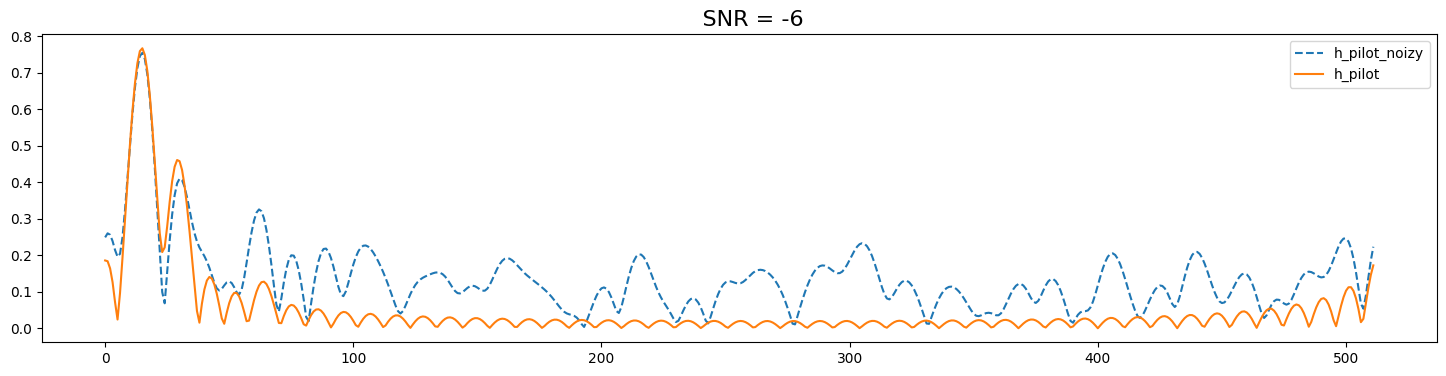

In [3]:

n_subc = 48 # число поднесущих
N_t = 64 # число приемных антенн
n_samples = 512 # кол-во отсчетов импульсной и частотной характеристики
ind = 85
SNR = -6 
seed = 5

h_pilot, h_data = data_load(scen0, ind=ind) # комплексные частотные характеристики для пилотных и информационных символов
h_pilot_noisy, _ = add_noise(h_pilot, SNR = SNR, seed=seed) # получаем зашумленный пилот
h_data_noisy, data_noise_power = add_noise_data(h_data, SNR = SNR, seed = seed)

h_ideal = h_pilot.mean(dim=2)
u = h_pilot_noisy.mean(dim=2)


plt.style.use('default')
plt.figure(figsize = (18,4))
plt.title('    SNR = ' +str(SNR), fontsize=16)
  # noizy h_pilot in freq domain -> time domain -> sqrt(re^2 + im^2)
u_print = ((upsampling(scen0, h = u[:,0:n_subc,:], inverse = False)**2)[:,:,0] + (upsampling(scen0, h = u[:,0:n_subc,:], inverse = False)**2)[:,:,1])**0.5
plt.plot(u_print[0,:], "--", label = 'h_pilot_noizy')
  # clear h_pilot in freq domain -> time domain -> sqrt(re^2 + im^2)
h_print = ((upsampling(scen0, h = h_pilot.mean(dim=2)[:,0:n_subc,:], inverse = False)**2)[:,:,0] + (upsampling(scen0, h = h_pilot.mean(dim=2)[:,0:n_subc,:], inverse = False)**2)[:,:,1])**0.5
plt.plot(h_print[0,:], label = 'h_pilot')
plt.legend()
plt.show()

In [4]:
from ch_est_net.Net import Net

net = Net(cfg)
optimizer = torch.optim.Adam(net.parameters() , lr = 1.0e-2 )

Created Net with  4 layers


In [5]:
from ch_est_net.criterion import MSE_detector_loss
from ch_est_net.Trainer import Trainer
criterion = MSE_detector_loss

trainer = Trainer(net, cfg, optimizer, criterion)


In [6]:
trainer.train_with_scenary(u, h_data_noisy, data_noise_power, scen0)

_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss =  tensor(0.0673, grad_fn=<DivBackward0>)
round =  6 , loss = 

In [27]:

'''Функция предсказания. Прогоняет данные для всех указанных SNR и файлов'''
def preds(NET = net, ml = ml_default, 
            lossVersion='detector', # 'detector' or 'relError'
            inds=range(1,141), 
            SNR_L=range(-10,-1), 
            seed=4, 
            max_iter=3, 
            ml_version=12, 
            SNRscaleFactor=1.,
            scen=scen0, scale=True):
    assert lossVersion in ['detector', 'relError']
    N_used = scen.RB_num*scen.RB_size
    loss = []
    comb = scen.comb

    z = torch.zeros(64, 512, 2, requires_grad = False)
    h_hat = torch.zeros(64, 512, 2, requires_grad = False) 

    losses = []

    if lossVersion == 'detector':
        N_pilot_sym = scen.N_pilot*scen.N_TTI
        N_data_sym = (14-N_pilot_sym)*scen.N_TTI;
        for SNR in SNR_L:
            loss_current = 0
            for ind in inds:
                h_pilot, h_data = data_load(scen, ind=ind+1 ,use_preloaded = False)
                h_pilot_noisy, _ = add_noise(h_pilot, SNR, seed=seed)
                h_data_noisy, data_noise_power = add_noise_data(h_data, SNR, seed=seed) 
                
                #u = torch.zeros([64, 512, 2], requires_grad= False)
                #u[:,0:n_subc,:] = h_pilot_noisy.mean(dim=2)
                u = h_pilot_noisy.mean(dim=2)


                # CHANNEL ESTIMATION # оценка канала 
                preds = NET.forward(u = u)
                h_pilot_rec = preds[:,:n_subc,:]
                
                # plot_h_hat_mean_for_file(h_hat = preds.detach(),
                #                          h_ideal = h_pilot.mean(dim=2),
                #                          u = h_pilot_noisy.mean(dim=2),
                #                          scen0 = scen0,
                #                          file_name = ind,
                #                          SNR = SNR,
                #                          save = True,
                #                          show = False
                #                          )

                # Show time domain recovered and initial signals
                if ind % 70==-1:
                    h_pilot_rec_numpy = upsampling(scen, h_pilot_rec, inverse=False).detach().numpy()
                    plt.plot(h_pilot_rec_numpy[0,:,0]**2+h_pilot_rec_numpy[0,:,1]**2)
                    h_f = h_pilot
                    if len(h_f.shape) == 4:
                        h_f = h_f.mean(dim=2)
                    h_f = upsampling(scen, h_f, inverse=False).detach().numpy()
                    plt.plot(h_f[0,:,0]**2+h_f[0,:,1]**2)
                    plt.show()            
                assert h_pilot_rec.shape[1] == N_used
                H_re = h_pilot_rec[:, :, 0]
                H_im = -h_pilot_rec[:, :, 1]
                
                # Detector error calculation
                err_data = 0
                for k in range (N_data_sym):    
                    det_data = torch.zeros((N_used, 2))   
                    assert h_data_noisy.shape[1] == N_used 
                    Y = h_data_noisy[:, :, k, :]                    
                    det_data[:,0] = (torch.sum(Y[:,:,0]*H_re-Y[:,:,1]*H_im, dim=0)/
                                    (data_noise_power+torch.sum(H_re**2+H_im**2, dim=0)))
                    det_data[:,1] = (torch.sum(Y[:,:,1]*H_re+Y[:,:,0]*H_im, dim=0)/
                                    (data_noise_power+torch.sum(H_re**2+H_im**2, dim=0)))
                      
                    err = det_data - torch.Tensor([1.,0.])  
                    err_data = err_data+torch.sum(err**2)
    
                loss_current += err_data/(N_data_sym*N_used)

                cur = {'loss': err_data.detach().numpy() ,'SNR': SNR, 'file': ind}
                losses.append(cur)

            loss.append(loss_current)        
            
    return loss, losses

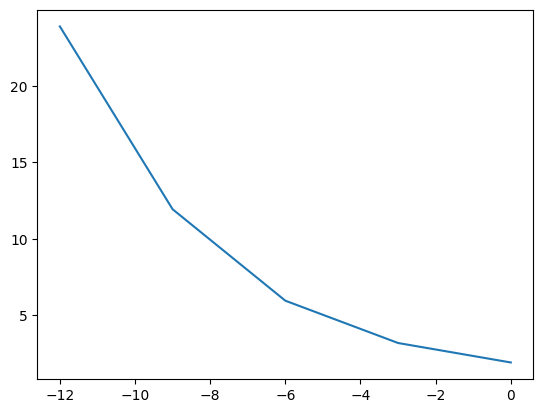

In [28]:
# Вызов функции
SNR_range = range(-12,1,3)
scenario_range =range(1, 140, 2)
detector_error_net, losses = preds(NET = net, 
            inds=scenario_range,
            scen = scen0,
            SNR_L=SNR_range)

import matplotlib.pyplot as plt
plt.style.use("default")
plt.plot(SNR_range, detector_error_net, 'o')